In [1]:
#pip install tensorflow

In [ ]:
#pip install sklearn

In [ ]:
#pip install matplotlib

In [ ]:
#pip install qiskit

## prepare

In [101]:
import warnings 
warnings.filterwarnings("ignore")

import numpy as np

# Importing standard Qiskit libraries
import qiskit
from typing import Dict, List
from qiskit import QuantumCircuit, transpile, Aer, execute
from qiskit.algorithms.optimizers import COBYLA
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector
from qiskit.quantum_info.operators import Operator

import pickle
from matplotlib import pyplot as plt

from tensorflow.keras.datasets import fashion_mnist
from sklearn.preprocessing import normalize

print("All packages imported successfully!")

All packages imported successfully!


In [2]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

In [3]:
data_shape = X_train[0].shape

## normalize

In [4]:
2**int(np.ceil(np.log2(X_train[0].size)))

1024

In [5]:
int(np.ceil(np.log2(X_train[0].size)))

10

In [6]:
def normalize(x):
    """
    """
    x = x.flatten()
    normalized_vector = x / np.linalg.norm(x)
    normalized_vector = [*normalized_vector]

    return normalized_vector

def de_normalize(normalized_vector, x):
    return normalized_vector * np.linalg.norm(x.flatten())

In [7]:
normalized_vector = np.array(normalize(X_train[0]))
de_normalized_vector = de_normalize(normalized_vector,np.array(X_train[0]))

In [8]:
np.allclose(
        X_train[0], np.reshape(np.array(de_normalized_vector[:784]),data_shape), rtol=1e-2
    )

True

In [9]:
X_train_list = []
for i in range(100):
    X_train_list.append(normalize(X_train[i]))

np.shape(X_train_list)

(100, 784)

In [10]:
X_test_list = []
for i in range(100):
    X_test_list.append(normalize(X_test[i]))
np.shape(X_test_list)

(100, 784)

## encoding

before normalize:


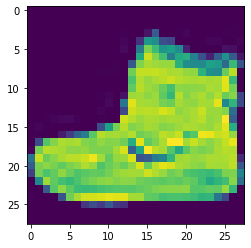

In [11]:
print('before normalize:')
display(plt.imshow(X_train[0]))

after normalize:


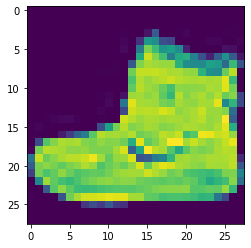

In [12]:
normalized_vector = normalize(X_train[0])
#print(normalized_vector)
print('after normalize:')
plt.imshow(np.reshape(np.array(normalized_vector[:784]),data_shape))

## circuit

In [13]:
state = normalized_vector
n = 10
qc = RawFeatureVector(2**n)
#qc = qc.bind_parameters(state)
#qc.measure_all()

#qc_ = qc.decompose(reps=20)
#print(qc_.depth())
#print(f"Circuit operations: {qc_.count_ops()}")
## qc.decompose(reps = 9).draw()
qc.num_parameters

1024

## test encoding & decoding (1st task)

In [14]:
import qiskit
from qiskit import BasicAer

def simulate(circ: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circ, backend,optimization_level=0)
    result = job.result()
    state_vector = result.get_statevector()
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        histogram[i] = population
    
    return histogram

In [15]:
def encode_qiskit(x,num_qubit):
    normalized_vector = normalize(x)
    qc = RawFeatureVector(2**num_qubit)
    # print("Number of pixels in each chunk is " + str(len(qc.parameters)))
    return qc.bind_parameters(normalized_vector)

def encode_shallow(n, image):
    # Getting the qubit number
    qubit = int(np.ceil(np.log2(n)))
    # print("Number of qubits is " + str(qubit))
    image = image.flatten()
    # Discretizing the image into chunks of size n
    state_chunks = [image[i * n:(i + 1) * n] for i in range((len(image) + n - 1) // n)]
    # print("Number of pixels in each chunk is " + str(len(state_chunks[0])))
    # List of PQCs
    qc_list = []
    for i in range(len(state_chunks)) : # Initializing the encoder
        if all(v == 0 for v in state_chunks[i]):
            qc_list.append(state_chunks[i])
        else:
            qc = encode_qiskit(state_chunks[i], qubit)
            qc_list.append(qc)
        
    return qc_list

def decode(histogram,data):
    new_histogram = {}
    for key in range(len(qc.parameters)):
        if key in histogram:
            new_histogram[key] = histogram[key]
        else:
            new_histogram[key] = 0
    #print(new_histogram)
    after_ = np.array(list(new_histogram.values()))
    return np.reshape(de_normalize(after_,data)[:784],data_shape)

def count_gates(circuit: qiskit.QuantumCircuit) -> Dict[int, int]:
    """Returns the number of gate operations with each number of qubits."""
    return Counter([len(gate[1]) for gate in circuit.data])

def image_mse(image1,image2):
    # Using sklearns mean squared error:
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
    return mean_squared_error(image1, image2)

In [38]:
def extract_image_re(data):
    histogram = []
    image_re = []
    hist_new = []
    circuit_list = encode_shallow(16, data)
    for i in range(len(circuit_list)):
        if all(v == 0 for v in circuit_list[i]):
            histogram.append(circuit_list[i])
        else:
            histogram.append(simulate(circuit_list[i]))
    
    for i in range(len(histogram)):
        if type(histogram[i]) is dict:
            temp = list(histogram[i].values())
            for j in range(16):
                hist_new.append(temp[j])
        else:
            for j in range(16):
                hist_new.append(histogram[i][j])
            
    print(len(hist_new))
    hist_new = hist_new / np.linalg.norm(hist_new)
    
    sum = 0
    for i in range(len(hist_new)):
        sum+=hist_new[i]**2
    print(sum)
    
    image_re = de_normalize(hist_new, X_train[0])
    print(image_re)
    return image_re, hist_new

In [39]:
#grade part1
#from part1 import encode_qiskit,decode
from collections import Counter
from sklearn.metrics import mean_squared_error

n=len(X_train)
mse=0
gatecount=0

dataset = X_train[:1]

for data in dataset:
    image_re,hist_vector = extract_image_re(data)    
    
    mse+=image_mse(np.asarray(data.flatten()),np.asarray(image_re))
    
#fidelity of reconstruction
f=1-mse/n
gatecount=gatecount/n

#score for part1
print(f*(0.999**gatecount))
# score should be between 0 and 1

784
0.9999999999999996
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

In [21]:
print(f*(0.999**gatecount))

0.7906032567632196


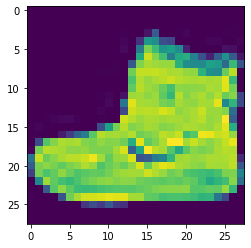

In [22]:
plt.imshow(data)

In [149]:
# 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'
def plot_image(image):
    # Reshape the list into a 28x28 array
    image = np.array(image).reshape(28, 28)
    # Plot the image using imshow
    plt.imshow(image, cmap = "Greys_r")
    # Remove the axis labels and ticks
    plt.axis('off')
    # Display the plot
    plt.show()

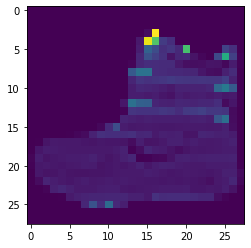

In [24]:
plt.imshow(np.array(image_re).reshape(28, 28))

## train classifier circuit (2nd task)
is there a way to get the best classifier?  

Important Final Note: The goal of this problem is to explore quantum computing approaches to machine learning problems. To this end, the final score will take into account the degree of quantumness in the program. Preference will be given to creative solutions with a minimal amount of classical processing in the final solution.

reference:   
[1] calculate result from probability, https://github.com/ericardomuten/quantum_image_classifier  
[2] MPS tensor circuit(ideal classifier circuit), https://journals.aps.org/prresearch/pdf/10.1103/PhysRevResearch.4.043007 , good example from qamp-mentorship https://github.com/qiskit-advocate/qamp-fall-22/issues/28   
[3] Good idea about amplitude circuit, https://journals.aps.org/prx/pdf/10.1103/PhysRevX.7.031041

In [98]:
def histogram_to_category(histogram):
    """This function take a histogram representations of circuit execution results, and process into labels as described in 
    the problem description."""
    positive=0
    label = ''
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
    
    if isclose(positive, 0, rel_tol=1e-1, abs_tol=0.0):
        label = "T-shirt/Top"
    elif isclose(positive, 1, rel_tol=1e-1, abs_tol=0.0):
        label = "Trousers"
    elif isclose(positive, 2, rel_tol=1e-1, abs_tol=0.0):
        label = "Pullover"
    elif isclose(positive, 3, rel_tol=1e-1, abs_tol=0.0):
        label = "Dress"
    elif isclose(positive, 4, rel_tol=1e-1, abs_tol=0.0):
        label = "Coat"
    elif isclose(positive, 5, rel_tol=1e-1, abs_tol=0.0):
        label = "Sandals"
    elif isclose(positive, 6, rel_tol=1e-1, abs_tol=0.0):
        label = "Shirt"
    elif isclose(positive, 7, rel_tol=1e-1, abs_tol=0.0):
        label = "Sneakers"
    elif isclose(positive, 8, rel_tol=1e-1, abs_tol=0.0):
        label = "Bag"
    elif isclose(positive, 9, rel_tol=1e-1, abs_tol=0.0):
        label = "Angle boots"
        
    return label

In [79]:
classifier = pickle.load(open("circuit.pickle", "rb"))

Traceback (most recent call last):
  Input In [79] in <cell line: 1>
    classifier = pickle.load(open("ansatz.pickle", "rb"))
FileNotFoundError: [Errno 2] No such file or directory: 'ansatz.pickle'

Use %tb to get the full traceback.


In [111]:
classifier = QuantumCircuit.from_qasm_file("iQuHACK/circuit.qasm")

In [102]:
classify_operator = Operator(ansatz)
hist_vec = [*hist_vector]
hist_vec.extend(np.zeros(240))

print(len(hist_vec))
hist_vec = Statevector(data = hist_vec)
output_statevector = hist_vec.evolve(classify_operator)

1024


In [105]:
features = []
for i in range(1024):
    features.append(bin(i)[2:].zfill(10))

output_statevector = list(i.real for i in output_statevector)

hist_dictionary = dict(zip(features, output_statevector))

In [106]:
histogram_to_category(hist_dictionary)

'Sneakers'